# Interpretable Multivariate Forecasting with Deep Learning
## **Exercise**: _Traffic & Construction (Part 2)_
### Workshop for ML Summit — scheduled for April 19th, 2020 2:15 PM CEST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Serg.ai](https://www.serg.ai/), [Github](https://www.serg.ai/), [Packt](https://www.packtpub.com/authors/serg-masis)) 

This notebook will walk through:

**PART II**

- Learn approach to approximate predictions using filter and distance functions
- Leverage [KernelExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html) to understand what features impact the outcome the most, both globally and locally. 

## 1) Install Libraries
#### _(if not installed already)_

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install --upgrade pandas numpy scikit-learn statsmodels tensorflow Keras matplotlib seaborn

Always installed unless installed already:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade distython shap

## 2) Preparations

Run every cell in this section:

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")

#DATA WRANGLING
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import get_file

#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#MODELING
import tensorflow as tf
from tensorflow import keras

#INTERPRETATION
from sklearn import metrics
from distython import HEOM
import shap

Using plaidml.keras.backend backend.


In [3]:
traffic_df = mldatasets.load("traffic-volume", prepare=True)

https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data/Metro_Interstate_Traffic_Volume.csv.gz
1 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data folder
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/presentations/ml-summit-2021/data/Metro_Interstate_Traffic_Volume.csv.gz


In [4]:
y_scaler = MinMaxScaler()
y_scaler.fit(traffic_df[['traffic_volume']])
X_scaler = MinMaxScaler()
X_scaler.fit(traffic_df.drop(['traffic_volume'], axis=1))

MinMaxScaler()

In [6]:
lookback = 672
y_all = y_scaler.transform(traffic_df[['traffic_volume']])
X_all = X_scaler.transform(traffic_df.drop(['traffic_volume'], axis=1))
gen_all = TimeseriesGenerator(X_all, y_all, length=672, batch_size=24)
print("gen_all_678:\t%s\t×\t%s\t→\t%s" % (len(gen_all),\
                                    gen_all[0][0].shape,\
                                    gen_all[0][1].shape))

gen_all_678:	1041	×	(24, 672, 14)	→	(24, 1)


In [12]:
X_df = traffic_df.drop(['traffic_volume'], axis=1).reset_index(drop=True)

In [7]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [8]:
model_path = get_file('LSTM_traffic_672_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/LSTM_traffic_672_final.hdf5?raw=true')
lstm_traffic_mdl = keras.models.load_model(model_path)
lstm_traffic_mdl.summary()

Model: "Traffic_Bidirectional_LSTM_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir_LSTM (Bidirectional)   (24, 672)                 943488    
_________________________________________________________________
Dropout (Dropout)            (24, 672)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   673       
Total params: 944,161
Trainable params: 944,161
Non-trainable params: 0
_________________________________________________________________


## 3) Computing global and local attributions with SHAP's KernelExplainer

### 3.1) Initial Setup

We will find the time series data that best suits the permutated input with existing examples from our `gen_all` generator. There are distance metrics we can use to find the one that is closest to the permutated input. However, we must place some guardrails because if the permutation is for a Saturday at 5 a.m. with a temperature of 27 degrees Celsius and 90 percent cloud coverage, the closest observation to this one could be on
a Friday at 7a.m., but regardless of the weather traffic, it would be completely different. Therefore, we can implement a filter function that ensures that it only finds closest observations for the same dow, is_holiday, and hr. The filter function can also clean up the permutated sample to remove or modify anything nonsensical for the model, such as a continuous value for a categorical feature:

![SHAP Strategy](https://github.com/smasis001/ml-summit-2021/blob/main/traffic_strategy.png)

#### Define Filter Function

It takes a pandas DataFrame with the entire dataset (`X_df`) you want to filter from, as well as the permutated sample (`x`) for filtering and the length of the lookback window. The function can also modify the permutated sample. In this case, we have to do this because so many features of the model are discrete, but the permutation process makes them continuous. All the filtering does is protect the distance function from finding a nonsensical closest sample to the permutated sample by limiting the options

In [52]:
def filt_fn(X_df, x, lookback):
    #print(x.tolist())
    x_ = x.copy()
    x_[0] = round(x_[0])
    x_[1] = round(x_[1])
    x_[4] = round(x_[4])
    x_[5] = round(x_[5])
    if x_[1] < 0:
        x_[1] = 24 + x_[1]
        x_[0] = x_[0] - 1
    if x_[0] < 0:
        x_[0] = 7 + x_[0]
    x_[6] = round(x_[6])
    x_[7] = round(x_[7])
    x_[8] = round(x_[8])
    x_[9] = round(x_[9])
    x_[10] = round(x_[10])
    x_[11] = round(x_[11])
    x_[12] = round(x_[12])
    x_[13] = round(x_[13])
    #if not (x==x_).all(): print('\t%s' % x_.tolist())
    X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
             (X_df.is_holiday==x_[5]) & (X_df.temp-5<=x_[2]) & (X_df.temp+5>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.is_holiday==x_[5]) & (X_df.temp-8<=x_[2]) & (X_df.temp+8>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.temp-11<=x_[2]) & (X_df.temp+11>=x_[2])]
    return X_filt_df, x_

#### Define Distance Function

We could use any standard distance function accepted by scipy.spatial.distance.cdist, such as "Euclidean," "cosine," or "Hamming." The problem with these standard distance functions is that they either work well with continuous or discrete variables but not both. We have both in this dataset!

Fortunately, some alternatives exist that can handle both, such as Heterogeneous Euclidean-Overlap Metric (HEOM). HEOM uses a normalized Euclidean ($\sqrt{(𝑎 − 𝑏)^2}$) for continuous and, for discrete, "overlap" distance; that is, a distance of zero if the same and one otherwise. Once the dataset has been filtered by day of week (`dow`) and hour (`hr`), the remaining discrete features are all binary, so "overlap" distance is ideal, and for the three remaining continuous features (`temp`, `rain_1h`, and `cloud_coverage`), Euclidean distance should suffice.

In [53]:
cat_idxs = np.where(traffic_df.drop(['traffic_volume'], axis=1).dtypes != np.float64)[0]
heom_dist = HEOM(X_df.values, cat_idxs)

In [54]:
print(cat_idxs)

[ 0  1  5  6  7  8  9 10 11 12 13]


#### Define Predict Function

In [55]:
predict_fn = lambda X: mldatasets.\
                        approx_predict_ts(X, X_df, gen_all, lstm_traffic_mdl,\
                              dist_metric=heom_dist.heom, lookback=lookback,\
                              filt_fn=filt_fn, X_scaler=X_scaler, y_scaler=y_scaler)

### 3.2) Define Scope for Attributions

In [ ]:
working_season_df = traffic_df[lookback:].drop(['traffic_volume'], axis=1).copy()
working_season_df = working_season_df[(working_season_df.index.month >= 5) &\
                                      (working_season_df.index.month <= 10)]

### 3.3) Initialize KernelExplainer

In [19]:
%%time
explainer = shap.KernelExplainer(predict_fn,\
                                 shap.kmeans(working_season_df.values, 10))

[3.0, 6.0, 15.220000000000027, 0.125, 40.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 6.0, 8.970000000000027, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 17.0, 18.160000000000025, 0.255, 90.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 17.0, 23.470000000000027, 0.0, 40.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 18.0, 22.620000000000005, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 7.0, 15.560000000000002, 0.125, 75.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 4.0, 18.590000000000032, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 13.0, 19.810000000000002, 0.0, 20.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 17.0, 22.920000000000016, 0.125, 75.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 6.0, 14.450000000000045, 0.2, 90.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CPU times: user 17.7 s, sys: 11.4 s, total: 29.1 s
Wall time: 5.92 s


### 3.4) Computing the SHAP Values

`KernelExplainer` is rather slow, especially when it's using our approximation method. We will sample 48 observations from it. To get an optimal global interpretation, it is best to use a high number of observations but also a high nsamples, which is the number of times we need to reevaluate the model when explaining each prediction. Unfortunately, having 50 of each would cause the explainer to take many hours to run, depending on your available compute, so we will use `nsamples=5`.

In [21]:
%%time
X_samp_df = working_season_df.sample(48, random_state=rand)
shap_values = explainer.shap_values(X_samp_df, nsamples=5)


CPU times: user 1h 37s, sys: 44min 57s, total: 1h 45min 35s
Wall time: 27min


### 3.5) Global Interpretation

Not surprisingly, hr and dow are the most important features, followed by some weather features. Strangely enough, temperature and rain don't seem to weigh in on the predictions, but late Spring through Fall may not be a significant factor. Or maybe more observations and a higher nsample will yield a better global interpretation:

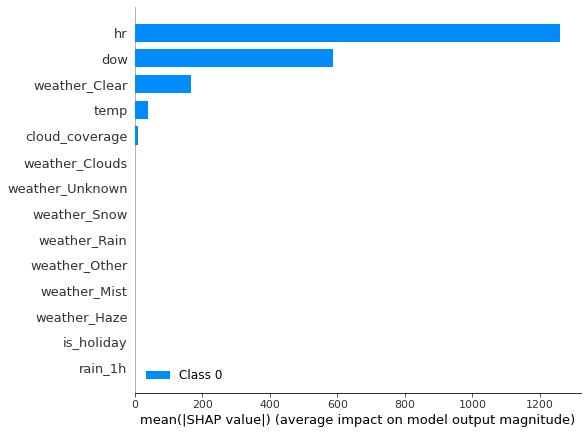

In [22]:
shap.summary_plot(shap_values, X_samp_df)

### 3.6) Local Interpretations

In [25]:
holiday_afternoon_s = X_df[(X_df.index >= 23471) & (X_df.dow==0) &\
                           (X_df.hr==16) & (X_df.is_holiday==1)]
peak_morning_s = X_df[(X_df.index >= 23471) & (X_df.dow==2) &\
                      (X_df.hr==8) & (X_df.weather_Clouds==1) &\
                      (X_df.temp<20)]
hot_saturday_s = X_df[(X_df.index >= 23471) & (X_df.dow==5) &\
                      (X_df.hr==12) & (X_df.temp>29)]

Let's iterate through all these datapoints. Then, we can produce a single shap_values but this time with nsamples=60, and then generate a `force_plot` for each one:

Holiday Afternoon


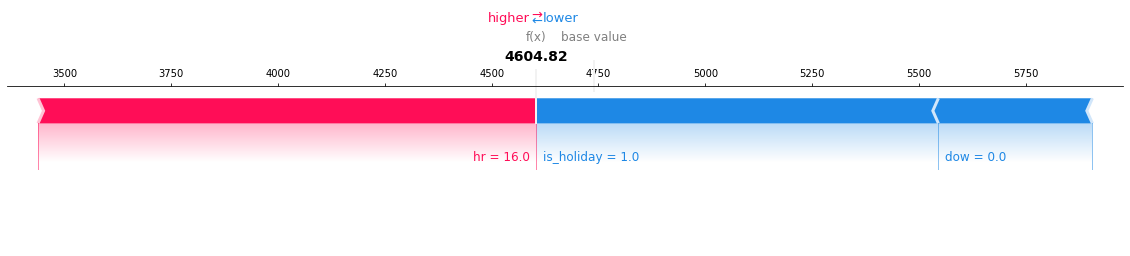

Peak Morning


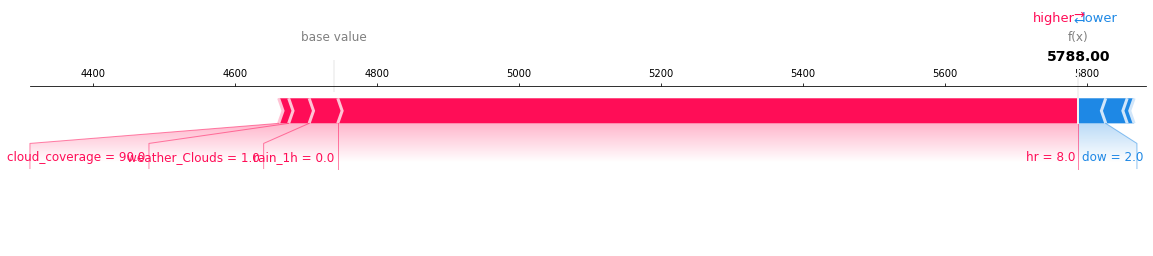

Hot Saturday


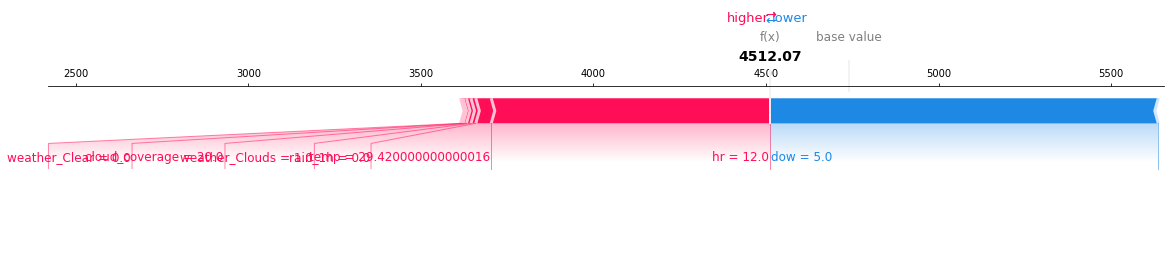

CPU times: user 43min 1s, sys: 32min 25s, total: 1h 15min 26s
Wall time: 18min 59s


In [26]:
%%time
datapoints = [holiday_afternoon_s, peak_morning_s, hot_saturday_s]
datapoint_labels = ['Holiday Afternoon', 'Peak Morning', 'Hot Saturday']
for i in range(len(datapoints)):
    print(datapoint_labels[i])
    shap_values_single = explainer.shap_values(datapoints[i], nsamples=60)
    shap.force_plot(explainer.expected_value, shap_values_single[0],\
                    datapoints[i], matplotlib=True)
    plt.show()

"Holiday afternoon" has the hour (hr=16) pushing toward a higher prediction, while the fact that it's a Monday (dow=0) and a holiday (is_holiday=1) is a driving force in the opposite direction. On the other hand, "Peak Morning" is mostly peak due to the hour (hr=8.0), but it has a high cloud_coverage, affirmative weather_Clouds, and yet no rain (rain_1h=0.0). Lastly, "Hot Saturday" has the day of week (dow=5) pushing for a lower value, but the abnormally high value is mostly due to it being midday and it having a collection of weather features, the most important of which is temp=29.42... (85°F).

In the real world, **variability is often determined by what is NOT represented in your data – but infinitesimally plausible**. For instance, reaching 25°C (77°F) before 5 a.m. in a Minneapolis summer is not a common occurrence, but with global warming, it could become frequent, so we would want to simulate how it could impact traffic patterns. Forecasting models are particularly prone to risk, so simulating is a crucial interpretation component to assess this uncertainty. A better understanding of uncertainty can yield more robust models or directly inform decisions. Next, we will discuss how we can produce simulations with sensitivity analysis methods.